In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [31]:
def johansen_cointegration_test(df):
    """
    Perform Johansen cointegration test on a multi-column DataFrame.

    Parameters:
    - df: pandas DataFrame, input data with multiple columns.

    Returns:
    - results_df: pandas DataFrame, containing the cointegration test results.
    """

    # Calculate log returns
    # returns = np.log(df / df.shift(1)).dropna()

    # Perform Johansen cointegration test
    result = coint_johansen(df, det_order=0, k_ar_diff=1)

    # Extract eigenvalues and cointegration vectors
    eigenvalues = result.eig
    coint_vectors = result.evec

    # Store cointegrating relationships and whether they are cointegrating
    cointegrating_relationships = {}
    for i, series in enumerate(df.columns):
        cointegrating_relationships[series] = {}
        for j, other_series in enumerate(df.columns):
            if i != j:
                cointegrating_relationships[series][other_series] = {
                    "cointegrating": abs(eigenvalues[i]) > result.cvm[i][2],
                    "cointegrating_vector": coint_vectors[i][j]
                }

    # Create a DataFrame to store the results
    results_df = pd.DataFrame(index=df.columns, columns=['Eigenvalue', 'Cointegrating', 'Cointegrating Vector'])

    # Populate the results DataFrame
    for series in df.columns:
        results_df.loc[series, 'Eigenvalue'] = eigenvalues[df.columns.get_loc(series)]
        results_df.loc[series, 'Cointegrating'] = any([
            cointegrating_relationships[series][other_series]['cointegrating']
            for other_series in df.columns if series != other_series
        ])
        if results_df.loc[series, 'Cointegrating']:
            results_df.loc[series, 'Cointegrating Vector'] = [
                cointegrating_relationships[series][other_series]['cointegrating_vector'][idx]
                for other_series in df.columns if series != other_series
                for idx in range(len(cointegrating_relationships[series][other_series]['cointegrating_vector']))
            ]

    return results_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


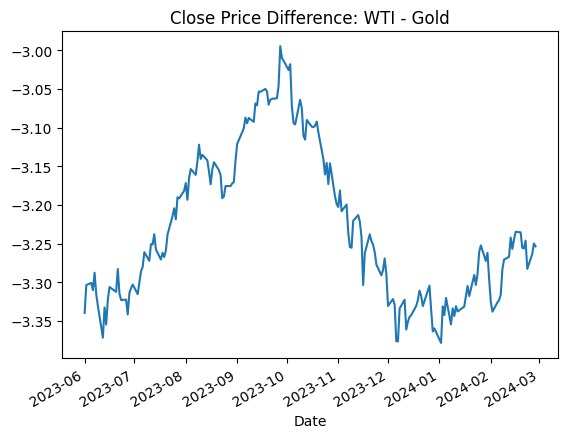

adf            -1.662867
p-value         0.450339
critical 1%    -3.465620
critical 5%    -2.877040
critical 10%   -2.575032
dtype: float64

Cointegration test results:
Test statistic: -14.594598459650523
Critical values: [-3.95596507 -3.36899945 -3.067208  ]


In [3]:
df_cl = yf.download('CL=F', interval='1d', start='2023-06-01', end='2024-02-29')
df_gc = yf.download('GC=F', interval='1d', start='2023-06-01', end='2024-02-29')

# df_cl = df_cl.loc[df_gc.index]

cl_close = df_cl.Close
gc_close = df_gc.Close

cl_diff = cl_close.diff().iloc[1:]
gc_diff = gc_close.diff().iloc[1:]

# df = pd.DataFrame(
#     {'wti': StandardScaler().fit_transform(cl_diff.values.reshape(-1, 1)).reshape(-1), 'gold': StandardScaler().fit_transform(gc_diff.values.reshape(-1, 1)).reshape(-1)},
#     index=cl_diff.index
# ).plot()
# plt.show()

df = pd.DataFrame(
    {'wti': cl_close.values, 'gold': gc_close.values},
    index=cl_close.index
)

df['diff'] = np.log(df['wti']) - np.log(df['gold'])
df['diff'].plot()
plt.title('Close Price Difference: WTI - Gold')
plt.show()

result = adfuller(df['diff'], autolag='AIC')
data = {
    'adf': result[0],
    'p-value': result[1],
}
for key, value in result[4].items():
    data[f'critical {key}'] = value

print(pd.Series(data))

test = coint(cl_diff, gc_diff)
print("\nCointegration test results:")
print("Test statistic:", test[0])
print("Critical values:", test[2])

- Since the test statistic is significantly lower (in absolute terms) than all of the critical values, it falls into the rejection region for all levels of significance. This suggests strong evidence against the null hypothesis of no cointegration.
- In other words, there is a statistically significant long-term relationship between crude oil futures and gold futures.
- The negative test statistic indicates a negative relationship between the two assets. This implies that when one asset's price increases, the other asset's price tends to decrease, and vice versa.

In [3]:
res_coint = coint_johansen(pd.DataFrame([cl_diff.values, gc_diff.values]).T, 0, 1)
trace_stats = res_coint.lr1
eigen_stats = res_coint.lr2

print(f'Trace:\n{trace_stats}\n')
print(f'Eigen:\n{eigen_stats}\n')
print(f'Critical Values:\n{res_coint.cvt}')

Trace:
[160.8221026   76.09753813]

Eigen:
[84.72456447 76.09753813]

Critical Values:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [4]:
coint(cl_diff, gc_diff)

(-14.85961452356393,
 1.4903403715751072e-26,
 array([-3.95596507, -3.36899945, -3.067208  ]))

# 2024 1 minute data

In [5]:
with pd.HDFStore('./large_files/data_20240312.h5') as store:
    df_cl = store.get('data/cl')
    df_cb = store.get('data/cb')
    df_gc = store.get('data/gc')

def filter_data(df):
    df = df.set_index('datetime', drop=False)
    df = df.loc[df.index.year.isin([2024])]
    df = df.loc[df.index.day_of_week == 2]
    df = df[(df.index.hour >= 9) & (df.index.hour < 12)]

    return df

df_cl = filter_data(df_cl)
df_cb = filter_data(df_cb)
df_gc = filter_data(df_gc)

# gc and cl is missing March 6
df_cb = df_cb.loc[df_gc.index]

In [39]:
def cointegration_test(sr1, sr2):
    result = coint(sr1, sr2)
    coint_stats = result[0]
    p_val = result[1]
    critical_values = result[2]

    return p_val

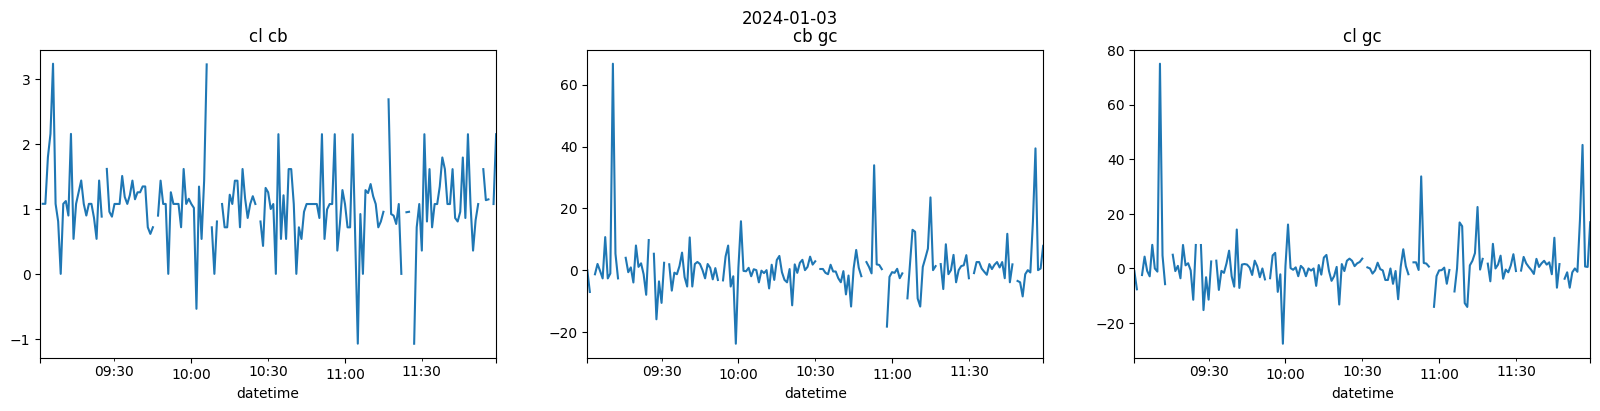

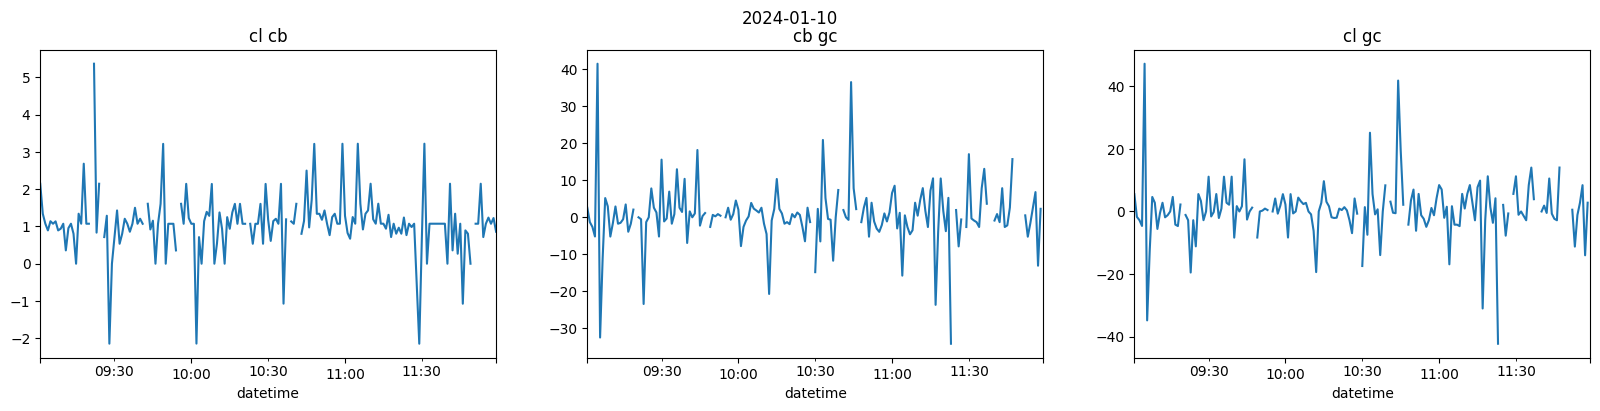

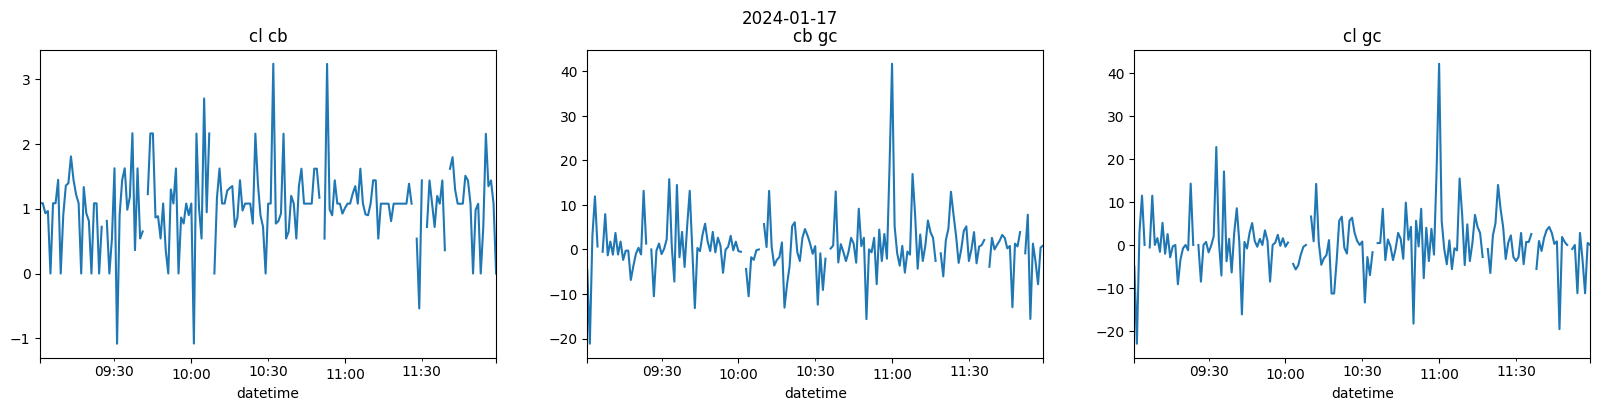

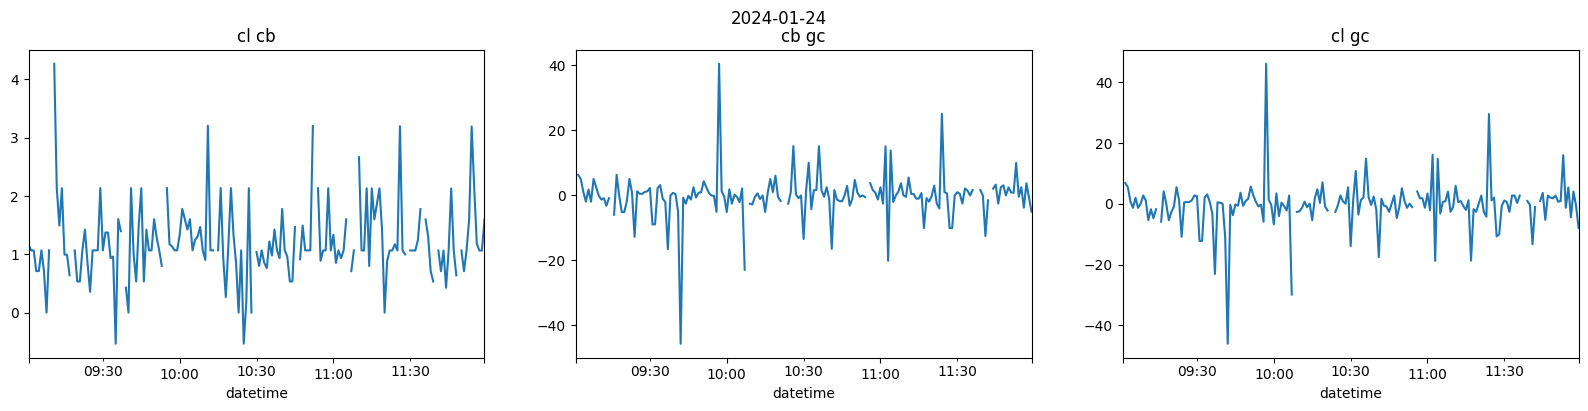

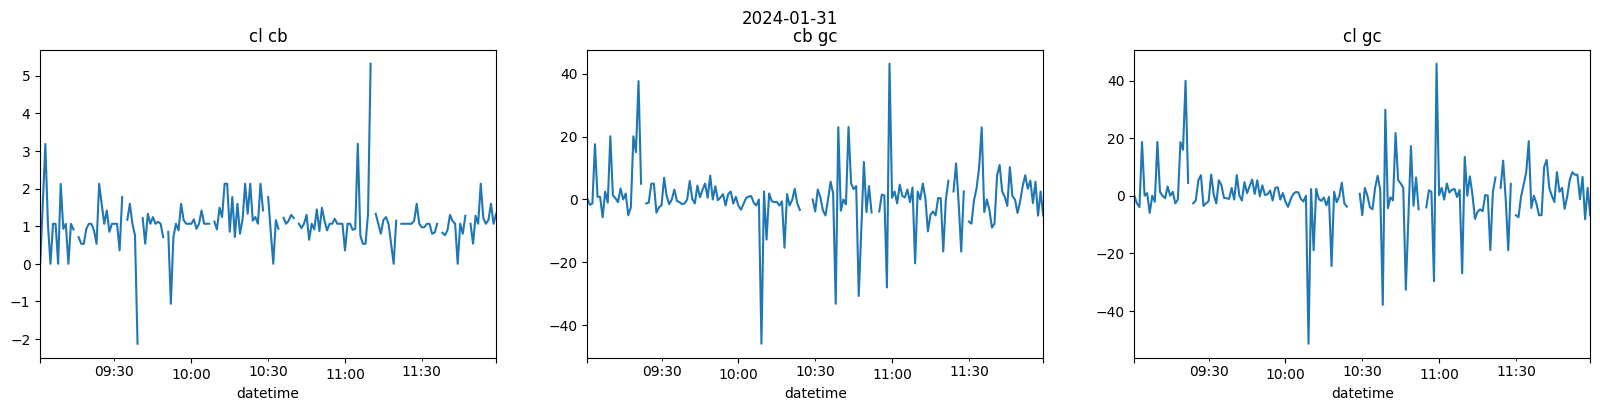

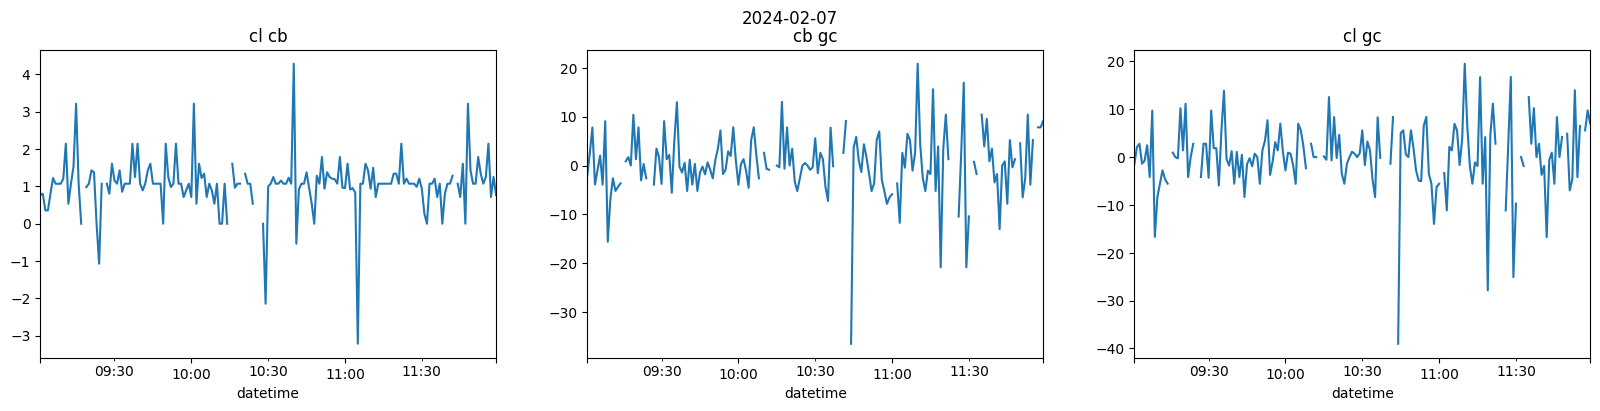

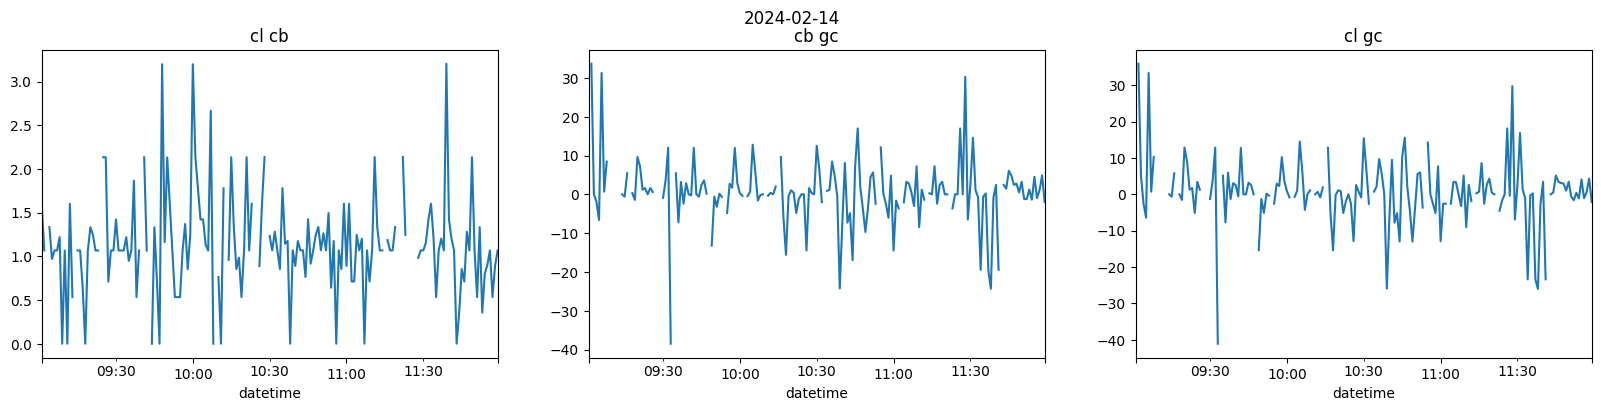

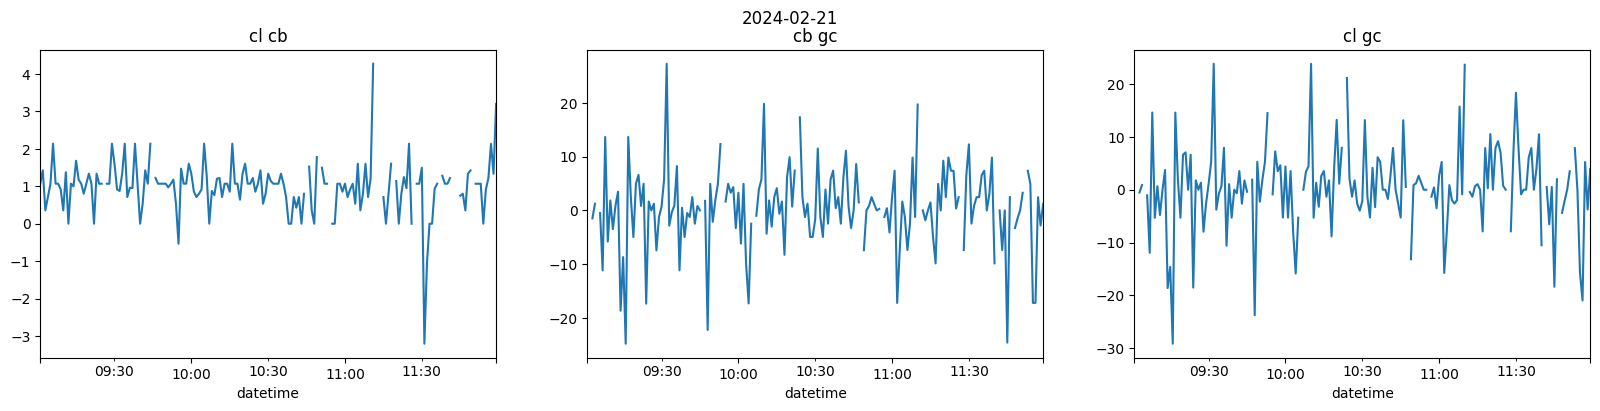

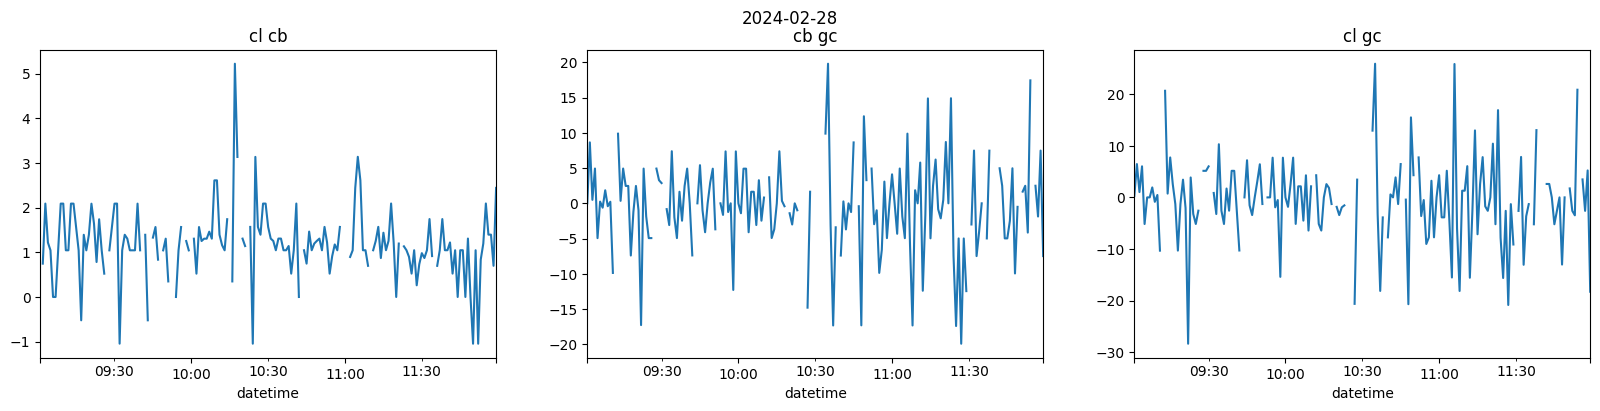

In [98]:
df_date = pd.Series(False, index=df_cb.index)
adf_results = []
for day, _ in df_date.groupby(pd.Grouper(freq='D')):
    df_day_cl = df_cl[df_cl.index.date == day.date()]
    df_day_cb = df_cb[df_cb.index.date == day.date()]
    df_day_gc = df_gc[df_gc.index.date == day.date()]

    if df_day_cl.shape[0] == 0:
        continue
    
    returns = pd.DataFrame({
        'cl': df_day_cl.close.pct_change(),
        'cb': df_day_cb.close.pct_change(),
        'gc': df_day_gc.close.pct_change()
    }).iloc[1:]
    
    result_cl_cb = cointegration_test(returns.cl, returns.cb)
    result_cb_gc = cointegration_test(returns.cb, returns.gc)
    result_cl_gc = cointegration_test(returns.cl, returns.gc)

    adf_cl_cb = adfuller(df_day_cl.close / df_day_cb.close)[1]
    adf_cb_gc = adfuller(df_day_cb.close / df_day_gc.close)[1]
    adf_cl_gc = adfuller(df_day_cl.close / df_day_gc.close)[1]

    adf_results.append({
        'cl_cb': adf_cl_cb,
        'cb_gc': adf_cb_gc,
        'cl_gc': adf_cl_gc
    })

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    plt.suptitle(day.date())
    (returns.cl / returns.cb).plot(title=f'cl cb', ax=axs[0])
    (returns.cb / returns.gc).plot(title=f'cb gc', ax=axs[1])
    (returns.cl / returns.gc).plot(title=f'cl gc', ax=axs[2])

    plt.show()

In [100]:
pd.DataFrame(adf_results)

,cl_cb,cb_gc,cl_gc
0,0.225152,0.015653,0.014684
1,0.526585,0.671239,0.701499
2,0.058568,0.422767,0.378002
3,0.972631,0.863538,0.903226
4,0.116391,0.592263,0.519063
5,0.156372,0.016010,0.018874
6,0.575143,0.894486,0.868733
7,0.985529,0.867853,0.920956
8,0.795116,0.962172,0.949322
